# Data Exploration & Cleaning Notebook

**Project**: Heart Disease Prediction

**Date**: 2026-01-20

The goals of this analysis are:

1) Perform a thorough analysis of the 

Column Descriptions:

| Var. Name | Original Name | Role | Type | Units | Notes |
|------|------|------|-------|-------|
|  age |      |predictor     |      |       |       |
|  sex |      | predictor      |      |       |       |
| Chest Pain  | predictor
| 
|
|

    id (Unique id for each patient)
    age (Age of the patient in years)
    origin (place of study)
    sex (Male/Female)
    cp chest pain type ([typical angina, atypical angina, non-anginal, asymptomatic])
    trestbps resting blood pressure (resting blood pressure (in mm Hg on admission to the hospital))
    chol (serum cholesterol in mg/dl)
    fbs (if fasting blood sugar > 120 mg/dl)
    restecg (resting electrocardiographic results)
    -- Values: [normal, stt abnormality, lv hypertrophy]
    thalach: maximum heart rate achieved
    exang: exercise-induced angina (True/ False)
    oldpeak: ST depression induced by exercise relative to rest
    slope: the slope of the peak exercise ST segment
    ca: number of major vessels (0-3) colored by fluoroscopy
    thal: [normal; fixed defect; reversible defect]
    num: the predicted attribute


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
# Load the datasets
data_path = Path('./data')
files = data_path.glob('*.data')

# Defining the column names 
cols = ["Age", "Sex", "Chest Pain", "Rest BP", "Chol", "FBS", "Rest ECG", "Max HR", "Ex Angina", "Oldpeak", "Slope", "Ca", "Thal", "CVD Class"]

dfs = [pd.read_csv(f, sep=",") for f in files]

# Assign the same column name to each dataframe
for df in dfs:
    df.columns = cols

df = pd.concat(dfs, ignore_index=True)


In [4]:
df.head()

,Age,Sex,Chest Pain,Rest BP,Chol,FBS,Rest ECG,Max HR,Ex Angina,Oldpeak,Slope,Ca,Thal,CVD Class
0,29.0,1.0,2.0,120,243,0,0,160,0,0.0,?,?,?,0
1,29.0,1.0,2.0,140,?,0,0,170,0,0.0,?,?,?,0
2,30.0,0.0,1.0,170,237,0,1,170,0,0.0,?,?,6,0
3,31.0,0.0,2.0,100,219,0,1,150,0,0.0,?,?,?,0
4,32.0,0.0,2.0,105,198,0,0,165,0,0.0,?,?,?,0


In [5]:
print(f"Dataset shape: {df.shape}")
print(f"Rows: {df.shape[0]:,}, Columns: {df.shape[1]}")

Dataset shape: (916, 14)
Rows: 916, Columns: 14


In [6]:
# Data types
print("\n=== Data Types ===")
print(df.dtypes.value_counts())
print("\nDetailed data types:")
print(df.dtypes)

# Basic info
print("\n=== Dataset Info ===")
df.info()


=== Data Types ===
object     10
float64     3
int64       1
Name: count, dtype: int64

Detailed data types:
Age           float64
Sex           float64
Chest Pain    float64
Rest BP        object
Chol           object
FBS            object
Rest ECG       object
Max HR         object
Ex Angina      object
Oldpeak        object
Slope          object
Ca             object
Thal           object
CVD Class       int64
dtype: object

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         916 non-null    float64
 1   Sex         916 non-null    float64
 2   Chest Pain  916 non-null    float64
 3   Rest BP     916 non-null    object 
 4   Chol        916 non-null    object 
 5   FBS         916 non-null    object 
 6   Rest ECG    916 non-null    object 
 7   Max HR      916 non-null    object 
 8   Ex Angina   916 non-null  

In [7]:
# Replacing all the question marks with NaN values
df = df.replace("?", np.nan)

missing_data = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})

missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

missing_data

,Missing_Count,Missing_Percentage
Ca,608,66.38
Thal,483,52.73
Slope,308,33.62
FBS,89,9.72
Oldpeak,62,6.77
Rest BP,59,6.44
Ex Angina,55,6.00
Max HR,55,6.00
Chol,30,3.28
Rest ECG,2,0.22


Here we face a dillema with the missing values. I'll break them down into two categories: high missingness (>30% missing) and low missingness (<10% missing).

I want to use the best approach possible for dealing with these features. For example, might it be better to perform imputation on the columns that have low missingness (<10% of total rows)? For those that have a significant number of missing values (Ca, Thal, Slope), perhaps performing some kind of unsupervised learning method to approximate the most likely value using other features would make sense? Perhaps simply dropping the features would be sufficient.

When looking at the description of the high missingness features, we see that they are all cardiac stress test results that require specialized equipment or procedures, which explains why a large quantity are missing. Because they are medically significant indicators of cardiac health, simply dropping these predictors will likely not improve the model's performance.

- **ca**: number of major vessels (0-3) colored by flourosopy

- **thal**: 3 = normal; 6 = fixed defect; 7 = reversable defect

- **slope**: the slope of the peak exercise ST segment 
    -- Value 1: upsloping 
    -- Value 2: flat 
    -- Value 3: downsloping

For the other values, using simple imputation is likely to be fine. 

In [16]:
missing_cols = missing_data.index 

# Create binary missingness indicators
missing_matrix = df[missing_cols].isnull().astype(int)
missing_matrix.columns = [f"{col}_missing" for col in missing_cols]

# Calculate co-occurrence (correlation of missingness)
cooccurrence = missing_matrix.corr()

cooccurrence.head(3).round(2)


,Ca_missing,Thal_missing,Slope_missing,FBS_missing,Oldpeak_missing,Rest BP_missing,Ex Angina_missing,Max HR_missing,Chol_missing,Rest ECG_missing
Ca_missing,1.00,0.71,0.49,0.19,0.19,0.19,0.18,0.18,0.12,0.03
Thal_missing,0.71,1.00,0.45,0.10,0.19,0.21,0.22,0.22,0.15,0.04
Slope_missing,0.49,0.45,1.00,-0.07,0.38,0.34,0.35,0.35,0.15,0.02


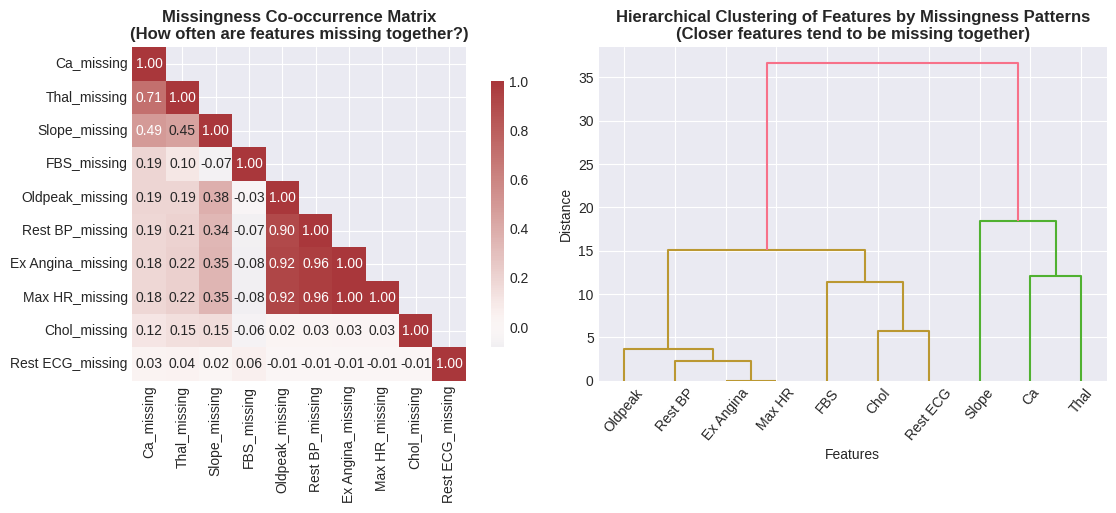

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Plotting the correlation of missing features
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
mask = np.triu(np.ones_like(cooccurrence, dtype=bool), k=1)
sns.heatmap(cooccurrence, annot=True, fmt='.2f', cmap='vlag',
            center=0, square=True, mask=mask, cbar_kws={"shrink": 0.8}, ax=ax[0])
ax[0].set_title('Missingness Co-occurrence Matrix', 
         fontweight='bold')


# Cluster features by missingness patterns
linkage_matrix = linkage(missing_matrix.T, method='ward')

dendrogram(linkage_matrix, labels=[col.replace('_missing', '') 
                                    for col in missing_matrix.columns],
           leaf_rotation=50, leaf_font_size=10, ax=ax[1])
ax[1].set_title('Hierarchical Clustering of Features by Missingness Patterns', fontweight='bold')
ax[1].set_xlabel('Features')
ax[1].set_ylabel('Distance')


plt.tight_layout()
plt.show()

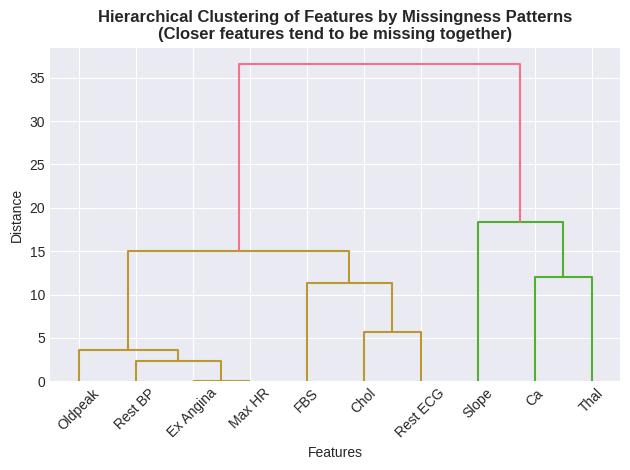

In [ ]:
# Numeric columns
numeric_cols = df.select_dtypes(include="number").columns.tolist()


print("\n=== Numerical Summary Statistics ===")
print(df[numeric_cols].describe())

# Check for potential outliers (values beyond 3 standard deviations)
print("\n=== Potential Outliers (beyond 3 std devs) ===")
for col in numeric_cols:
    mean = df[col].mean()
    std = df[col].std()
    outliers = df[(df[col] < mean - 3*std) | (df[col] > mean + 3*std)][col].count()
    if outliers > 0:
        print(f"{col}: {outliers} potential outliers ({(outliers/len(df)*100):.2f}%)")


=== Numerical Summary Statistics ===
              Age        Sex  Chest Pain   CVD Class
count  916.000000  916.00000  916.000000  916.000000
mean    53.541485    0.78821    3.255459    0.996725
std      9.370073    0.40880    0.925783    1.143760
min     29.000000    0.00000    1.000000    0.000000
25%     47.000000    1.00000    3.000000    0.000000
50%     54.000000    1.00000    4.000000    1.000000
75%     60.000000    1.00000    4.000000    2.000000
max     77.000000    1.00000    4.000000    4.000000

=== Potential Outliers (beyond 3 std devs) ===

=== Categorical Summary ===

Rest BP:
  Unique values: 102

Chol:
  Unique values: 334

FBS:
  Unique values: 4
  Value counts:
FBS
0      432
0.0    258
1       93
1.0     44
Name: count, dtype: int64

Rest ECG:
  Unique values: 6
  Value counts:
Rest ECG
0      319
0.0    231
2.0    174
1.0     96
1       82
2       12
Name: count, dtype: int64

Max HR:
  Unique values: 197

Ex Angina:
  Unique values: 4
  Value counts:
Ex Angina


In [ ]:
# Categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()


unique_count = df[categorical_cols].nunique()

unique_count


Rest BP      102
Chol         334
FBS            4
Rest ECG       6
Max HR       197
Ex Angina      4
Oldpeak       81
Slope          6
Ca             7
Thal           6
dtype: int64